In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta, datetime
from matplotlib import font_manager, rc
from matplotlib.ticker import MaxNLocator

from IPython.display import Image # 이미지 삽입

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['figure.figsize'] = [25,15]
plt.rcParams['font.size'] = 25

In [2]:
# outliar 제거 함수 (IQR 설정) (1)
def remove_out(dataframe, remove_col) :
    dff = dataframe
    for k in remove_col :
        level_1q = dff[k].quantile(0.25)
        level_3q = dff[k].quantile(0.75)
        IQR = level_3q - level_1q
        rev_range = 1.5
        outliar_h = dff[k] >= level_3q + (rev_range * IQR)
        outliar_l = dff[k] <= level_1q - (rev_range * IQR)
        a=dff[outliar_h].index
        b=dff[outliar_l].index
        dff.drop(a, inplace=True)
        dff.drop(b, inplace=True)

#그래프 2개 비교 (차이 비교) -- 숫자를 표시안함
def difference(dataframe1, dataframe2) :    
    diff = np.subtract(dataframe1,dataframe2)
    
    # diff가 0보다 작은 index 찾는 것
    diff_down = dataframe2.loc[diff.loc[diff < 0].index]
    display(diff_down.index)
    
    # diff의 값을 평균내는 부분
    print(diff.describe())
    
    # 20%인 위치 값 찾기
    try :
        sorted_diff = diff.sort_values()
        ten_percent_index = int(len(sorted_diff) * 0.1)
        ten_percent_value = sorted_diff.iloc[ten_percent_index]
        print("10% value: ", ten_percent_value)
    except IndexError as e:
        if "single positional indexer is out-of-bounds" in str(e):
            print("매우나쁨 농도가 없습니다.")
        else:
            raise e
    finally :
        # 숫자 넣는 부분, height + 0.25로 숫자 약간 위로 위치하게 조정
        plt.plot(dataframe1.index,diff)
        for i in range(len(dataframe1.index)):
            height = diff[i]
            plt.text(dataframe1.index[i], height + 0.01, '%.2f' %height, ha='center', va='bottom', size = 25)
        plt.title("Difference between airm-airKorea")
        plt.xlabel("Hour")
        plt.ylabel("diff")
        plt.show()
    
# 아림의 미세먼지 농도가 매우나쁨 이상일 때, airKorea의 미세먼지 농도의 평가
def air_quality_label(pm25):
    if pm25 <= 15:
        return '좋음'
    elif pm25 <= 35:
        return '보통'
    elif pm25 <= 75:
        return '나쁨'
    else:
        return '매우 나쁨'

C:\Users\ASUS\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


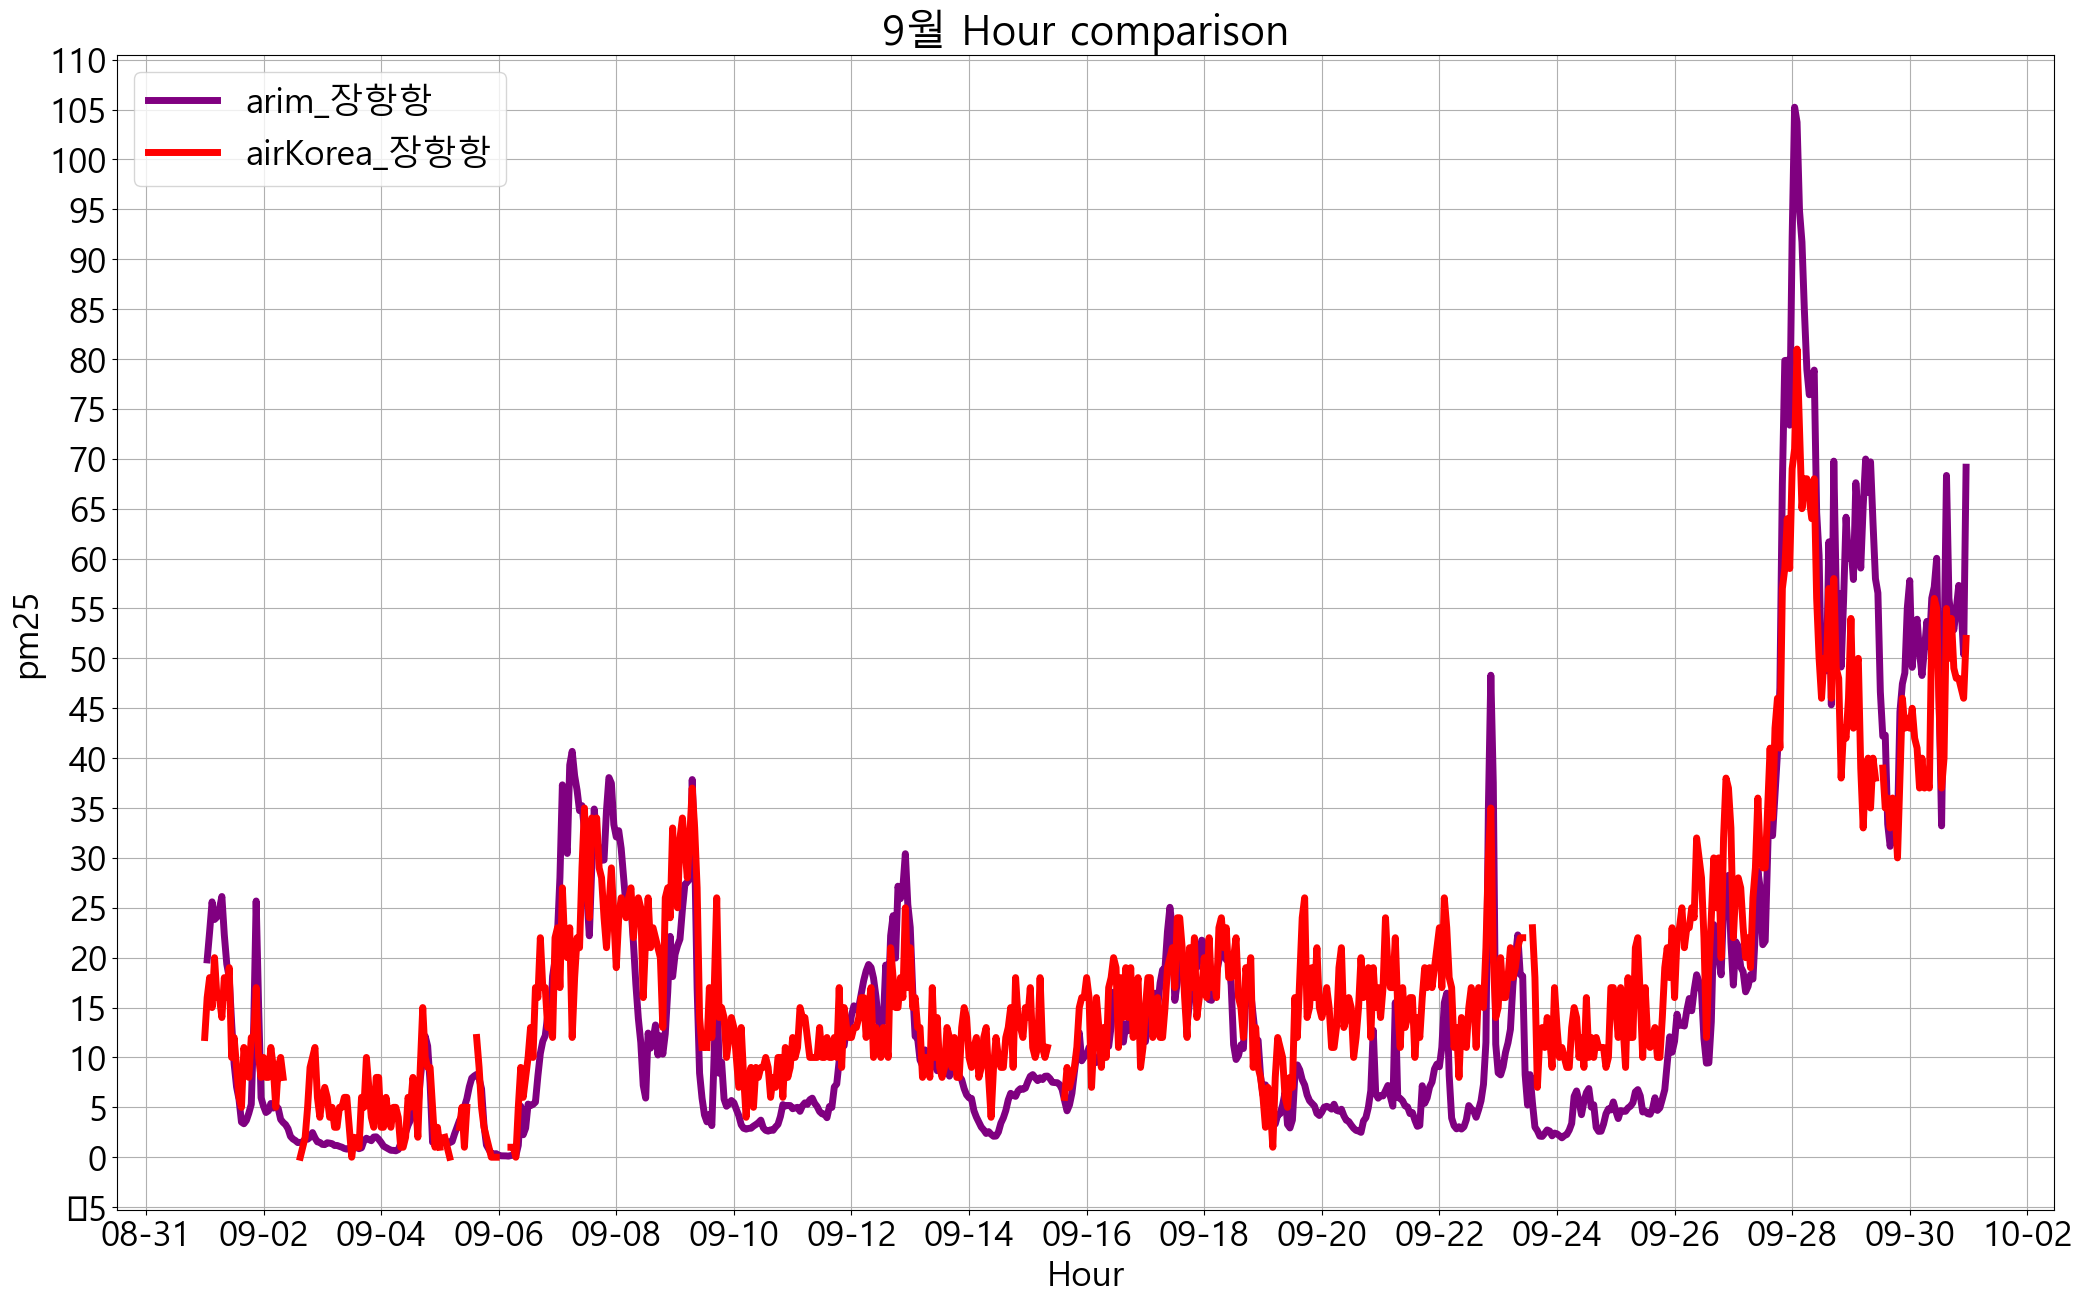

In [3]:
arim_data = pd.read_csv('./비교/장항항/9월/OA200#1_9월 MA.csv')
airKorea_data = pd.read_csv('./비교/장항항/9월/airkorea_장항항_9월.csv')

arim_data['date'] = arim_data.date.apply(pd.to_datetime)
airKorea_data['date'] = airKorea_data.date.apply(pd.to_datetime)

arim_data = arim_data.groupby([pd.Grouper(key='date', freq='H')]).mean()
airKorea_data = airKorea_data.groupby([pd.Grouper(key='date', freq='H')]).mean()

# 그래프 2개 비교
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=25))
plt.plot(arim_data.index, arim_data['PM2.5'], color="purple", linewidth="5")
plt.plot(airKorea_data.index, airKorea_data['PM2.5'], color="red", linewidth="5")
plt.xlabel('Hour')
plt.ylabel('pm25')
plt.legend(('arim_장항항','airKorea_장항항'))
plt.title('9월 Hour comparison')
plt.grid()
plt.show()

In [23]:
arim_data = pd.read_csv('./비교/장항항/9월/OA200#1_9월 MA.csv')
airKorea_data = pd.read_csv('./비교/장항항/9월/airkorea_장항항_9월.csv')

arim_data['date'] = arim_data.date.apply(pd.to_datetime)
airKorea_data['date'] = airKorea_data.date.apply(pd.to_datetime)

arim_data = arim_data.groupby([pd.Grouper(key='date', freq='H')]).mean()
airKorea_data = airKorea_data.groupby([pd.Grouper(key='date', freq='H')]).mean()

# 좋음,보통,나쁨,매우나쁨 기준 나누기
airKorea_data['air_quality_label_air'] = airKorea_data['PM2.5'].apply(lambda x: air_quality_label(x))
arim_data['air_quality_label_arim'] = arim_data['PM2.5'].apply(lambda x: air_quality_label(x))

# airKorea_data에서 '보통'일 때와 '나쁨'일 때의 인덱스 가져오기
airKorea_index = airKorea_data[airKorea_data['air_quality_label_air'].isin(['보통', '나쁨'])].index

# arim_data에서 '보통'일 때와 '나쁨'일 때의 인덱스 가져오기
arim_index = arim_data[arim_data['air_quality_label_arim'].isin(['보통', '나쁨'])].index

idx = list(set(arim_index).union(set(airkorea_index)))

arim_data = arim_data.reindex(idx)
airKorea_data = airKorea_data.reindex(idx)


result = pd.concat([arim_data, airKorea_data], axis=1)
result.drop(['PM10','O3','NO2','CO','SO2'],axis=1, inplace=True)
result = result.sort_index()

# 데이터 프레임 한번에 전체 다 보기
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(result)
print(result.info())

,PM2.5,air_quality_label_arim,PM2.5,air_quality_label_air
date,,,,
2022-09-01 01:00:00,19.778333,보통,16.0,보통
2022-09-01 02:00:00,22.600000,보통,18.0,보통
2022-09-01 03:00:00,25.593333,보통,15.0,좋음
2022-09-01 04:00:00,23.825000,보통,20.0,보통
2022-09-01 05:00:00,24.070000,보통,16.0,보통
2022-09-01 06:00:00,24.886667,보통,16.0,보통
2022-09-01 07:00:00,26.130000,보통,14.0,좋음
2022-09-01 08:00:00,22.270000,보통,18.0,보통
2022-09-01 09:00:00,19.363333,보통,16.0,보통


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 351 entries, 2022-09-01 01:00:00 to 2022-09-30 23:00:00
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PM2.5                   351 non-null    float64
 1   air_quality_label_arim  351 non-null    object 
 2   PM2.5                   349 non-null    float64
 3   air_quality_label_air   351 non-null    object 
dtypes: float64(2), object(2)
memory usage: 13.7+ KB
None


,PM2.5,air_quality_label_arim,PM2.5,air_quality_label_air
date,,,,
2022-09-01 03:00:00,25.593333,보통,15.0,좋음
2022-09-01 07:00:00,26.130000,보통,14.0,좋음
2022-09-01 22:00:00,15.135000,보통,10.0,좋음
2022-09-06 15:00:00,5.525000,좋음,17.0,보통
2022-09-06 16:00:00,8.140000,좋음,16.0,보통
...,...,...,...,...
2022-09-29 12:00:00,46.633333,나쁨,NaN,매우 나쁨
2022-09-29 14:00:00,42.311667,나쁨,35.0,보통
2022-09-29 15:00:00,33.390000,보통,36.0,나쁨


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 165 entries, 2022-09-01 03:00:00 to 2022-09-30 13:00:00
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PM2.5                   165 non-null    float64
 1   air_quality_label_arim  165 non-null    object 
 2   PM2.5                   163 non-null    float64
 3   air_quality_label_air   165 non-null    object 
dtypes: float64(2), object(2)
memory usage: 6.4+ KB
None


In [24]:
# arim과 air이 다를때를 따로 찾아보기
mask = result['air_quality_label_arim'] != result['air_quality_label_air']
mismatched_rows = result[mask]
# 데이터 프레임 한번에 전체 다 보기
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(mismatched_rows)
print(mismatched_rows.info())

# 아림이 좋음 or 보통 일때,     air가 나쁨 or 매우나쁨
# 아림이 나쁨 or 매우나쁨 일때, air가 좋음 or 보통

,PM2.5,air_quality_label_arim,PM2.5,air_quality_label_air
date,,,,
2022-09-01 03:00:00,25.593333,보통,15.0,좋음
2022-09-01 07:00:00,26.130000,보통,14.0,좋음
2022-09-01 22:00:00,15.135000,보통,10.0,좋음
2022-09-06 15:00:00,5.525000,좋음,17.0,보통
2022-09-06 16:00:00,8.140000,좋음,16.0,보통
2022-09-06 17:00:00,10.405000,좋음,22.0,보통
2022-09-06 18:00:00,11.625000,좋음,17.0,보통
2022-09-06 19:00:00,12.181667,좋음,17.0,보통
2022-09-06 22:00:00,18.140000,보통,12.0,좋음


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 165 entries, 2022-09-01 03:00:00 to 2022-09-30 13:00:00
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PM2.5                   165 non-null    float64
 1   air_quality_label_arim  165 non-null    object 
 2   PM2.5                   163 non-null    float64
 3   air_quality_label_air   165 non-null    object 
dtypes: float64(2), object(2)
memory usage: 6.4+ KB
None
